# Project 3 Team 5
## Date: 17 January 2025 

1. Project Overview
2. Data Load and preprocessing
3. Model training
4. Evaluation
5. Deployment

### 1. Project Overview

### 2. Data load and preprocessing 
#### Packages

In [ ]:
pip install scikeras

In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow-model-optimization

In [ ]:
pip install mlflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn 
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import mlflow
import mlflow.sklearn
import scikeras
from scikeras.wrappers import KerasClassifier
import pickle
from mlflow.models import infer_signature

from urllib.parse import urlparse
import json
from scipy.sparse import csr_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import csr_matrix, vstack

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, normalize

import nltk
import re
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tcala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tcala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tcala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tcala\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Datasets

In [2]:
#importing the dataset:the train dataset 
train_df = pd.read_csv("Data/processed/train.csv")
# train_df.head(5)

In [3]:
#importing the dataset: the test 
test_df = pd.read_csv("Data/processed/test.csv")
# test_df.head(5)

<h3>2.1 Data inspection</h3>

In [4]:
print("The dimensions for the Train set are:", train_df.shape)
print("The dimensions for the test set are:",test_df.shape)

The dimensions for the Train set are: (5520, 5)
The dimensions for the test set are: (2000, 5)


In [5]:
display(train_df.info(), test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520 entries, 0 to 5519
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   headlines    5520 non-null   object
 1   description  5520 non-null   object
 2   content      5520 non-null   object
 3   url          5520 non-null   object
 4   category     5520 non-null   object
dtypes: object(5)
memory usage: 215.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   headlines    2000 non-null   object
 1   description  2000 non-null   object
 2   content      2000 non-null   object
 3   url          2000 non-null   object
 4   category     2000 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


None

None

There are no missing values in both the train and test dataset

In [6]:
null_counts = pd.DataFrame({
    "Train Null Count": train_df.isnull().sum(),
    "Test Null Count": test_df.isnull().sum()
})
print(null_counts)

             Train Null Count  Test Null Count
headlines                   0                0
description                 0                0
content                     0                0
url                         0                0
category                    0                0


In [7]:
display(train_df.duplicated().sum(), test_df.duplicated().sum())

0

0

Number of duplicate for train set rows: 0

Number of duplicate for test set rows: 0

In [8]:
def inspect_dataset(df):
    return {
        "Number of Rows": df.shape[0],
        "Number of Columns": df.shape[1],
        "Total Missing Values": df.isnull().sum().sum(),
        "Duplicate Rows": df.duplicated().sum(),
        "Numerical Columns": df.select_dtypes(include='number').shape[1],
        "Categorical Columns": df.select_dtypes(include='object').shape[1],
    }

train_inspection = inspect_dataset(train_df)
test_inspection = inspect_dataset(test_df)

inspection_results = pd.DataFrame({
    "Metric": train_inspection.keys(),
    "Train Dataset": train_inspection.values(),
    "Test Dataset": test_inspection.values(),
})

print(inspection_results)

                 Metric  Train Dataset  Test Dataset
0        Number of Rows           5520          2000
1     Number of Columns              5             5
2  Total Missing Values              0             0
3        Duplicate Rows              0             0
4     Numerical Columns              0             0
5   Categorical Columns              5             5


In [9]:
train_df.describe().T
#check if there are duplicates 

,count,unique,top,freq
headlines,5520,5512,International Education Day 2024: Know why it ...,2
description,5520,5508,The university has removed the requirements of...,2
content,5520,5513,Grand Slam fever grips tennis fans all over th...,5
url,5520,5514,https://indianexpress.com/article/education/kc...,2
category,5520,5,education,1520


In [10]:
categories = train_df.category.unique()
print(test_df.head())

                                           headlines  \
0  NLC India wins contract for power supply to Ra...   
1  SBI Clerk prelims exams dates announced; admit...   
2  Golden Globes: Michelle Yeoh, Will Ferrell, An...   
3  OnePlus Nord 3 at Rs 27,999 as part of new pri...   
4  Adani family’s partners used ‘opaque’ funds to...   

                                         description  \
0  State-owned firm NLC India Ltd (NLCIL) on Mond...   
1  SBI Clerk Prelims Exam: The SBI Clerk prelims ...   
2  Barbie is the top nominee this year, followed ...   
3  New deal makes the OnePlus Nord 3 an easy purc...   
4  Citing review of files from multiple tax haven...   

                                             content  \
0  State-owned firm NLC India Ltd (NLCIL) on Mond...   
1  SBI Clerk Prelims Exam: The State Bank of Indi...   
2  Michelle Yeoh, Will Ferrell, Angela Bassett an...   
3  In our review of the OnePlus Nord 3 5G, we pra...   
4  Millions of dollars were invested in some p

<h3>2.2. Data Preprocessing</h3>

<h4> Preprocessing function that tokenizes, removes stop words and lematizes the text</h4>

In [4]:
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stop_words = [word for word in tokens if word.lower() not in stop_words]

    # Remove punctuation
    no_puntuation = [word for word in no_stop_words if word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in no_puntuation]

    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


In [5]:
columns_to_process = ['headlines', 'description', 'content'] #We will deal with URLs later

for col in columns_to_process:
    train_df[col] = train_df[col].apply(preprocess_text)
    test_df[col] = test_df[col].apply(preprocess_text)

In [ ]:
print(train_df.head())
print(test_df.head())

<h4> Handling URLs</h4>

The URL columns may not always reliably provide information on the category, so we drop the column. Even if the column has the category, this may negatively impact our model performance as this will lead to 100% accuracy in our models on training data. This is unrealistic as in practice, URLs may not have the category in them or in the expected sequence, causing the model to perform poorly.

In [6]:
train_df = train_df.drop(columns='url', axis=1)
test_df = test_df.drop(columns='url', axis=1)

train_df.head()

,headlines,description,content,category
0,RBI revise definition person KYC purpose,central bank also asked chairperson chief exec...,Reserve Bank India RBI changed definition Pers...,business
1,NDTV Q2 net profit fall Rs crore impacted lowe...,NDTV consolidated revenue operation Rs crore R...,Broadcaster New Delhi Television Ltd Monday re...,business
2,Akasa Air well capitalised grow much faster CE...,initial share sale open public subscription Ju...,Homegrown server maker Netweb Technologies Ind...,business
3,India current account deficit decline sharply ...,current account deficit CAD per cent GDP USD b...,India current account deficit declined sharply...,business
4,States borrowing cost soar highest far fiscal,price shot reflecting overall higher risk aver...,States forced pay nose weekly auction debt Tue...,business


<h3> Train-test Split and Vectorizing</h3>

Before using a TF-IDF vectorizer to draw out important words that may help predict an article's category, we will perform a train-test split to get a validation set, which we can also vectorize.

First, we will separate the predictor variables from the response variable (category) for both the train and test data. Then we'll define the vectorizing function, and finally vectorize the data to be used later by models.

In [11]:
# First, combine the text features
train_df['text'] = train_df['headlines'] + ' ' + train_df['content'] + ' ' + train_df['description']
test_df['text'] = test_df['headlines'] + ' ' + test_df['content'] + ' ' + test_df['description']

# Then, split the data
X = train_df['text']
y = train_df['category']

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_test_base = test_df['text']
y_test_base = test_df['category']


In [42]:
def get_tfidf_vectorizers_per_category(X, y, n=5000):
    category_vectorizers = {}

    for category in y.unique():
        vectorizer = TfidfVectorizer(stop_words='english', max_features=n)
        X_category = X.loc[y == category]  # Ensure correct indexing
        vectorizer.fit(X_category)
        category_vectorizers[category] = vectorizer

    return category_vectorizers

# Generate vectorizers using only training data
category_vectorizers = get_tfidf_vectorizers_per_category(X_train_base, y_train_base)


In [44]:
# Apply transformation per category
X_train_transformed = pd.DataFrame(
    np.vstack([category_vectorizers[cat].transform(X_train_base).toarray() for cat in category_vectorizers]),
    columns=category_vectorizers[list(category_vectorizers.keys())[0]].get_feature_names_out()
)
y_train_expanded = np.hstack([[cat] * len(X_train_base) for cat in category_vectorizers]) 

X_val_transformed = pd.DataFrame(
    np.vstack([category_vectorizers[cat].transform(X_val_base).toarray() for cat in category_vectorizers]),
    columns=category_vectorizers[list(category_vectorizers.keys())[0]].get_feature_names_out()
)
y_val_expanded = np.hstack([[cat] * len(X_val_base) for cat in category_vectorizers])

X_test_transformed = pd.DataFrame(
    np.vstack([category_vectorizers[cat].transform(X_test_base).toarray() for cat in category_vectorizers]),
    columns=category_vectorizers[list(category_vectorizers.keys())[0]].get_feature_names_out()
)
y_test_expanded = np.hstack([[cat] * len(X_test_base) for cat in category_vectorizers])


<h2>Handling Class Imbalances</h2> 

Now, we will check if the categories have an equal spread of observations. If there is a class imbalance this can lead to overfitting and models being able to predict the majority categories better, while poorly predicting the minority categories.

In [50]:
#Getting an idea of the counts of each category
y_train.value_counts()

category
education        1216
technology       1024
business          896
entertainment     768
sports            512
Name: count, dtype: int64

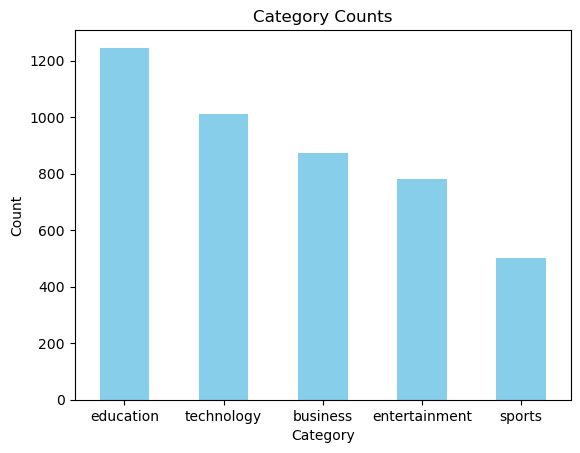

In [79]:
#Storing the count of each category, which will be used later for visualising them
category_counts = y_train.value_counts()

#Plotting a bar graph that shows the differing counts of each category
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


From this bar graph we can clearly see that there is a class imbalance within the training data. If not addressed, this could lead the model to being good at predicting the majority categories (education and technology) and not so much the minorities (sports and entertainment). To ensure that the model is equally effectivce at predicting all the categories, we will implement both upsampling and downsampling on the categories below.

Before we can actually handle the class imbalance, we need to make sure that the data is in a useable format. We currently have dictionaries that have key features for each category, and we need to combine these features into one DataFrame such that we can perform upsampling and downsampling

In [232]:
top_words_per_category = {}

for category, vectorizer in category_vectorizers.items():
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(vectorizer.idf_)[::-1]  # Sort by importance
    top_5000 = feature_array[tfidf_sorting][:5000]  # Top 5000 words
    top_words_per_category[category] = top_5000

# Display the top n words
n = 5
for category, words in top_words_per_category.items():
    print(f"Top words for {category}: {', '.join(words[:n])}")


Top words for entertainment: pooh, mandalorian, trap, traumatic, mai
Top words for technology: 007, cowriter, crawler, reparent, crd
Top words for business: hiranandani, b737, krithivasan, bata, sia
Top words for education: producer, jk, cabe, jalan, sankaran
Top words for sports: zu, mum, muneeba, murali, murder


<h4>Sampling</h4>

In [66]:
# Combine X and y into a DataFrame for resampling
train_data = X_train_transformed.copy()
train_data['category'] = y_train_expanded

# Define the target size per class
target_len = int(len(y_train) / len(y_train.unique())) 

# Balance the dataset
balanced_data = []

# Looping through all the unique categories and sampling them to match the target length
for category in train_data['category'].unique():
    category_data = train_data[train_data['category'] == category]

    if len(category_data) > target_len:
        downsampled = resample(category_data, replace=False, n_samples=target_len, random_state=42)
        balanced_data.append(downsampled)

    elif len(category_data) < target_len:
        upsampled = resample(category_data, replace=True, n_samples=target_len, random_state=42)
        balanced_data.append(upsampled)

    else:
        balanced_data.append(category_data)

# Combine balanced data
final_balanced_data = pd.concat(balanced_data)


In [35]:
# Extract final X_train and y_train
X_train = final_balanced_data.drop(columns = ['category'])
y_train = final_balanced_data['category']

In [37]:
y_train.value_counts()

category
education        883
sports           883
technology       883
entertainment    883
business         883
Name: count, dtype: int64

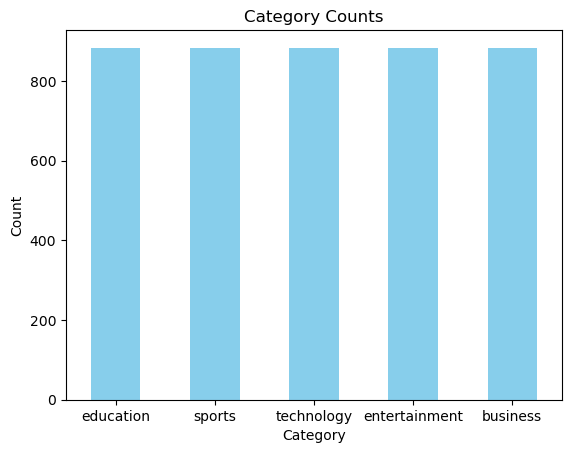

In [110]:
category_counts = y_train.value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


As we can see, all the categories have been resampled to where they have the same number of observations.

<h1>Models</h1>

<h2>Neural Network</h2>

In [187]:
# Convert sparse matrices to dense numpy arrays, if they are sparse
X_train_nn = X_train.toarray() if isinstance(X_train_base, csr_matrix) else np.asarray(X_train_base)
X_val_nn = X_val.toarray() if isinstance(X_val_transformed, csr_matrix) else np.asarray(X_val_transformed)
X_test_nn = X_test.toarray() if isinstance(X_test_transformed, csr_matrix) else np.asarray(X_test_transformed)

# Ensure the arrays are 2D before slicing
X_train_nn = X_train_nn.reshape(-1, X_train_nn.shape[-1]) if X_train_nn.ndim == 1 else X_train_nn
X_val_nn = X_val_nn.reshape(-1, 1) if X_val_nn.ndim == 1 else X_val_nn  # Reshape correctly if it's 1D
X_test_nn = X_test_nn.reshape(-1, 1) if X_test_nn.ndim == 1 else X_test_nn  # Reshape correctly if it's 1D


# Now slice the dense arrays to keep only the first 4999 columns (if needed)
# We use 4999 because while handling class imbalances, we lost an observation 
# while trying to equalize the number of observations per class
X_val_nn = X_val_nn[:, :4999]
X_test_nn = X_test_nn[:, :4999]


In [189]:
# Initialise the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform them
y_train_nn = label_encoder.fit_transform(y_train)
y_val_nn = label_encoder.transform(y_val_expanded)
y_test_nn = label_encoder.transform(y_test_expanded)


In [191]:
# Hyperparameters
input_dims = X_train.shape[1]
batch_size = 32
epochs = 10
num_classes = len(y_train.unique())


In [193]:
#Creating the Neural network
model_nn = Sequential([
    Input(shape=(X_train.shape[1],)), # Input Layer
    Dense(4500, activation='relu',),  # First hidden layer
    Dropout(0.3),  # Regularization
    Dense(3500, activation='relu'),  # Second hidden layer
    Dropout(0.2),  # Regularization
    Dense(1000, activation='relu'),  # Third hidden layer
    Dropout(0.2),  # Regularization
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

<h4>Training</h4>

In [196]:
# Compile the model
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Uncomment the code below to fit the model outside of MLFlow

In [201]:
# model_nn.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=epochs, batch_size=batch_size)

# test_loss, test_accuracy = model_nn.evaluate(X_test_nn, y_test_nn, batch_size=32)

# # Print results
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 490ms/step - accuracy: 0.8130 - loss: 0.4575 - val_accuracy: 0.6455 - val_loss: 1.6048
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 494ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.6643 - val_loss: 1.5773
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 488ms/step - accuracy: 1.0000 - loss: 1.5790e-06 - val_accuracy: 0.6705 - val_loss: 1.5142
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 489ms/step - accuracy: 1.0000 - loss: 5.5959e-07 - val_accuracy: 0.6710 - val_loss: 1.5100
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 496ms/step - accuracy: 1.0000 - loss: 3.3485e-07 - val_accuracy: 0.6719 - val_loss: 1.5098
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - accuracy: 1.0000 - loss: 2.6471e-07 - val_accuracy: 0.6726 - val_loss: 1.5103
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - accuracy: 1.0000 - loss: 2.0851e-07 - val_accuracy: 0.6736 - val_loss: 1.5115
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 497ms/step - accura

Test Loss: 1.5150614976882935

Test Accuracy: 0.6721000075340271

<h4>Model Tuning</h4>

In [362]:
def create_nn_model(optimizer='adam', dropout_rate=0.2, num_units=64):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(4500, activation='relu',),
        Dropout(0.3),
        Dense(3500, activation='relu'),
        Dropout(0.2), 
        Dense(1000, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax') 
    ])
    # Compile model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

In [223]:
model_nn_tune = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0, dropout_rate=0.2)


In [203]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30],
    'loss': ['sparse_categorical_crossentropy', 'binary_crossentropy']
}


Running the following code cell will take a while as it is going a while as it is performing a significant number of tests in an attenmpt to to find the best combination of parameters that will yield the best performing neural network 

In [ ]:
#Using GridSearchCV to get the best hyperparameters for the NN model
grid_search = GridSearchCV(estimator=model_nn_tune, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train_nn, y_train_nn)

# Get the best hyperparameters
print("Best parameters found: ", grid_search.best_params_)

Identified best parameters: {optimizer: 'adam', loss: 'sparse_categorical_crossentropy', dropout_rate: 0.2, epochs: 10, batch_size: 32}

<h4>Testing the 'best' model</h4>

In [205]:
model_best = Sequential([
    Input(shape=(input_dims,)),  
    Dense(4500, activation='relu'),
    Dropout(0.3),
    Dense(3500, activation='relu'),
    Dropout(0.2), 
    Dense(1000, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') 
])

In [208]:
model_best.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Uncomment the code below to fit the model outside of MLFlow

In [210]:
# model_best.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=epochs, batch_size=batch_size)

# test_loss, test_accuracy = model_best.evaluate(X_test_nn, y_test_nn, batch_size=32)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 71s 502ms/step - accuracy: 0.8137 - loss: 0.4591 - val_accuracy: 0.5284 - val_loss: 3.1932
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 488ms/step - accuracy: 0.9992 - loss: 0.0049 - val_accuracy: 0.6442 - val_loss: 1.7267
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 501ms/step - accuracy: 0.9987 - loss: 0.0017 - val_accuracy: 0.6062 - val_loss: 2.1737
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 73s 525ms/step - accuracy: 1.0000 - loss: 1.5317e-06 - val_accuracy: 0.6141 - val_loss: 2.1180
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 492ms/step - accuracy: 1.0000 - loss: 4.2255e-07 - val_accuracy: 0.6147 - val_loss: 2.1062
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 489ms/step - accuracy: 1.0000 - loss: 2.6268e-07 - val_accuracy: 0.6156 - val_loss: 2.0973
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 489ms/step - accuracy: 1.0000 - loss: 1.6996e-07 - val_accuracy: 0.6163 - val_loss: 2.0916
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 485ms/step - accuracy: 

Test Loss: 2.0039327144622803

Test Accuracy: 0.6279000043869019

<h4>MLFlow</h4>

The following function will, using MLFlow, create an experiment that will track the model passed to it, and log its parameters and metrics

In [53]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [61]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model, model_name):

    with mlflow.start_run(run_name = model_name):
        # Log hyperparameters
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("input_dims", input_dims)
        mlflow.log_param("num_classes", num_classes)

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_val, y_val), verbose=1)

        # Log final validation metrics
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)

        # Evaluate on test data
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        y_pred_classes = y_pred.argmax(axis=1)
        y_true_classes = y_test.argmax(axis=1)

        # Generate classification report
        report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
        mlflow.log_dict(report, "classification_report.json")

        # #logging the model
        signature = infer_signature(X_train.iloc[:5].to_numpy(), model.predict(X_train.iloc[:5].to_numpy()))
        mlflow.keras.log_model(model, "Neural Network model", signature=signature)

    return model

In [63]:
train_and_evaluate_model(X_train_nn, y_train_nn, X_val_nn, y_val_nn, X_test_nn, y_test_nn, model_nn, model_name = "Base Model - 5K Features")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 347ms/step - accuracy: 0.3674 - loss: 2.9879 - val_accuracy: 0.2645 - val_loss: 2.3512
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 343ms/step - accuracy: 0.8919 - loss: 0.3293 - val_accuracy: 0.2038 - val_loss: 2.7418
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 341ms/step - accuracy: 0.9749 - loss: 0.0973 - val_accuracy: 0.2255 - val_loss: 4.7027
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 338ms/step - accuracy: 0.9851 - loss: 0.0690 - val_accuracy: 0.2246 - val_loss: 5.2176
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - accuracy: 0.9901 - loss: 0.0645 - val_accuracy: 0.2418 - val_loss: 5.7826
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 343ms/step - accuracy: 0.9931 - loss: 0.0549 - val_accuracy: 0.2183 - val_loss: 4.9632
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 340ms/step - accuracy: 0.9968 - loss: 0.0222 - val_accuracy: 0.2174 - val_loss: 6.5120
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - accuracy: 0.9872 - loss: 0

<Sequential name=sequential, built=True>

In [65]:
train_and_evaluate_model(X_train_nn, y_train_nn, X_val_nn, y_val_nn, X_test_nn, y_test_nn, model_best, model_name = "Tuned Model - 5K features")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.3544 - loss: 2.8042 - val_accuracy: 0.2681 - val_loss: 2.3383
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 56s 403ms/step - accuracy: 0.8963 - loss: 0.3209 - val_accuracy: 0.2582 - val_loss: 2.8981
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 48s 346ms/step - accuracy: 0.9711 - loss: 0.1247 - val_accuracy: 0.2246 - val_loss: 4.1228
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 46s 333ms/step - accuracy: 0.9847 - loss: 0.0800 - val_accuracy: 0.2328 - val_loss: 4.7747
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 0.9905 - loss: 0.0608 - val_accuracy: 0.2409 - val_loss: 5.1767
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 0.9926 - loss: 0.0636 - val_accuracy: 0.2264 - val_loss: 4.5103
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 0.9970 - loss: 0.0162 - val_accuracy: 0.2219 - val_loss: 5.3069
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - accuracy: 0.9943 - loss: 0

<Sequential name=sequential_1, built=True>

Having looked at the models' performance on MLFlow, the tuned model outperformed the base model and now, it will be registered and saved for export and future use.

<h5>Registering the better performing model</h5>

In [71]:
model_name = "Tuned Model"
run_id = input("Enter Run ID: ") #"4cc744832cfa4cd3b3e2080144b83c84"
model_uri = f"runs:/{run_id}/{model_name}"

result = mlflow.register_model(
    model_uri, model_name
)

Enter Run ID:  dcc1ab545a1f4cb098e5058efaffea9a


Registered model 'Tuned Model' already exists. Creating a new version of this model...
2025/02/06 00:16:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Tuned Model, version 6
Created version '6' of model 'Tuned Model'.


In [117]:
filename = "NN_model.pkl"
pickle.dump(model_best, open(filename, "wb"))

<h2>Random Forest</h2>

MLFlow Setup

In [18]:
#Setting the tracking URI, which is where MLFlow will run and log experiments
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("RF_Category_Models")

<Experiment: artifact_location='mlflow-artifacts:/754615274060752379', creation_time=1738929522016, experiment_id='754615274060752379', last_update_time=1738929522016, lifecycle_stage='active', name='RF_Category_Models', tags={}>

In [36]:
# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit the vectorizer on the training data and transform the data
X_train_transformed = vectorizer.fit_transform(X_train_base)
X_val_transformed = vectorizer.transform(X_val_base)
X_test_transformed = vectorizer.transform(X_test_base)

# Label encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_base)
y_val_encoded = label_encoder.transform(y_val_base)
y_test_encoded = label_encoder.transform(y_test_base)


In [37]:
# Function to calculate feature importance per category
def get_feature_importance_per_category(X_train, y_train, vectorizer, n_top_features=5000):
    category_importances = {}

    # Loop through each category
    for category in np.unique(y_train):
        # Filter data for the current category
        X_category = X_train[y_train == category]
        y_category = y_train[y_train == category]
        
        # Train a RandomForest for the category to get feature importances
        rf_model = RandomForestClassifier(n_estimators=5, random_state=42)
        rf_model.fit(X_category, y_category)
        
        # Get feature importances
        importances = rf_model.feature_importances_
        feature_names = vectorizer.get_feature_names_out()

        # Create a DataFrame for feature importances
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort features by importance and select the top ones
        sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(n_top_features)
        
        # Store the important features for the category
        category_importances[category] = sorted_features

    return category_importances
    

In [40]:
# Calculate the important features per category
category_importances = get_feature_importance_per_category(X_train_transformed, y_train_encoded, vectorizer)

<h4>Training</h4>

In [43]:
# Function to train and log the base Random Forest model
def train_base_rf_and_log(X_train, y_train, vectorizer):
    with mlflow.start_run() as run:  # Start an MLFlow run to log the base model
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

         # Log parameters of the base model
        mlflow.log_param('n_estimators', 100)
        mlflow.log_param('max_depth', 10)
        mlflow.log_param('random_state', 42)
        
        rf_model.fit(X_train, y_train)  # Train the model on the entire dataset
        
        mlflow.sklearn.log_model(rf_model, "rf_model_base")  # Log the base model
        
    return rf_model
    

In [45]:
# Train and log the base model
rf_model_base = train_base_rf_and_log(X_train_transformed, y_train_encoded, vectorizer)


2025/02/07 14:28:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run brawny-snipe-821 at: http://127.0.0.1:5000/#/experiments/754615274060752379/runs/848e4ff5834a44789671066bef9af0a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/754615274060752379


#### Model Tuning

In [46]:
# Function to tune the Random Forest model using GridSearchCV and log the tuned model
def train_tuned_rf_and_log(X_train, y_train, vectorizer):
    with mlflow.start_run() as run:  # Start an MLFlow run to log the tuned model
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None]
        }
        
        rf_model = RandomForestClassifier(random_state=42)

        # Log the parameters for the GridSearchCV
        mlflow.log_param('param_grid', str(param_grid))
        
        grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_rf_model = grid_search.best_estimator_

         # Log the best parameters of the tuned model
        best_params = grid_search.best_params_
        for param, value in best_params.items():
            mlflow.log_param(param, value)
            
        mlflow.sklearn.log_model(best_rf_model, "rf_model_tuned")  # Log the tuned model
        
    return best_rf_model
    

In [47]:
# Train and log the tuned model
rf_model_tuned = train_tuned_rf_and_log(X_train_transformed, y_train_encoded, vectorizer)


2025/02/07 14:29:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adorable-rat-838 at: http://127.0.0.1:5000/#/experiments/754615274060752379/runs/103dc99a28a54b4c9c26c1ae97d02345
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/754615274060752379


<h4>Evaluation</h4>

In [48]:
def evaluate_rf_per_category(models, X_val, y_val, vectorizer, category_importances, n_top_features=5000):
    # Identify the top `n_top_features` across all categories
    all_important_features = []

    for category, importance_df in category_importances.items():
        all_important_features.extend(importance_df['Feature'].values)

    # Deduplicate and sort to get the most important features overall
    all_important_features = list(set(all_important_features))[:n_top_features]

    # Get the indices of these features in the original feature space
    feature_indices = [np.where(vectorizer.get_feature_names_out() == feature)[0][0] for feature in all_important_features]
    
    # Convert the validation set to the required format
    X_val_important = X_val[:, feature_indices]

    for model_name, model in models.items():
        with mlflow.start_run() as run:  # Log evaluation for each category and model
            for category in np.unique(y_val):
                # Filter the validation set for the current category
                y_val_category = y_val[y_val == category]
                X_val_category_important = X_val_important[y_val == category]
                
                # Predict and calculate accuracy
                y_val_pred = model.predict(X_val_category_important)
                accuracy = (y_val_pred == y_val_category).mean()

                # Log evaluation results for this category
                mlflow.log_metric(f"accuracy_{model_name}_category_{category}", accuracy)
                print(f"Validation Accuracy for {model_name} - category {category}: {accuracy}")



Validation Accuracy for base - category 0: 0.08928571428571429
Validation Accuracy for base - category 1: 0.3355263157894737
Validation Accuracy for base - category 2: 0.0
Validation Accuracy for base - category 3: 0.015625
Validation Accuracy for base - category 4: 0.76953125
🏃 View run skittish-snipe-81 at: http://127.0.0.1:5000/#/experiments/754615274060752379/runs/3ee73fe7514d442280f2c4bce4294ce7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/754615274060752379
Validation Accuracy for tuned - category 0: 0.04017857142857143
Validation Accuracy for tuned - category 1: 0.22039473684210525
Validation Accuracy for tuned - category 2: 0.020833333333333332
Validation Accuracy for tuned - category 3: 0.2421875
Validation Accuracy for tuned - category 4: 0.62109375
🏃 View run fearless-vole-210 at: http://127.0.0.1:5000/#/experiments/754615274060752379/runs/396da175c5fa4ef297afefe3d7ec65a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/754615274060752379


In [ ]:
# Evaluate both the base and tuned models using the important features and log results
models = {'base': rf_model_base, 'tuned': rf_model_tuned}
evaluate_rf_per_category(models, X_val_transformed, y_val_encoded, vectorizer, category_importances)

In [ ]:
import joblib
joblib.dump(rf_model_tuned, "Random_Forest_model.pkl")
print("Model saved as 'Random_Forest_model.pkl'")


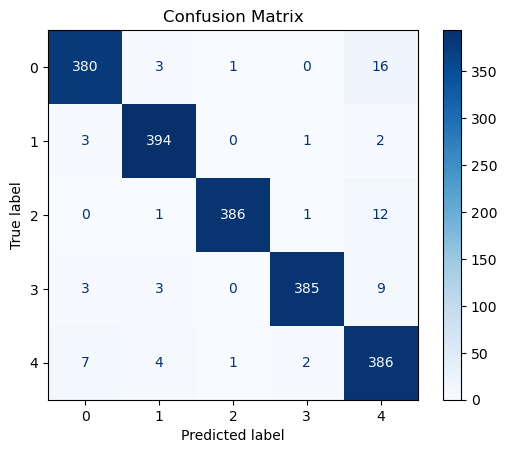

In [321]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model_tuned, X_test_transformed, y_test_encoded, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Trim the importances array to match the number of features
importances = importances[:len(features)]


In [ ]:
# Create the DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order and take the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 most important features
print(importance_df)


<h2>K-Nearest Neighbours</h2>

In [77]:
X_train_knn = X_train_base
y_train_knn = y_train_base

X_test_knn = X_val_base
y_test_knn = y_val_base

In [279]:
# Convert sparse matrices to dense numpy arrays, if they are sparse
X_train_knn = X_train.toarray() if isinstance(X_train, csr_matrix) else np.asarray(X_train)
X_val_knn = X_val.toarray() if isinstance(X_val, csr_matrix) else np.asarray(X_val)
X_test_knn = X_test.toarray() if isinstance(X_test, csr_matrix) else np.asarray(X_test)

# Ensure the arrays are 2D before slicing
X_train_knn = X_train_knn if X_train_knn.ndim == 2 else X_train_knn.reshape(-1, 1)
X_val_knn = X_val_knn if X_val_knn.ndim == 2 else X_val_knn.reshape(-1, 1)
X_test_knn = X_test_knn if X_test_knn.ndim == 2 else X_test_knn.reshape(-1, 1)


# Now slice the dense arrays to keep only the first 4999 columns (if needed)
# We use 4999 because while handling class imbalances, we lost an observation 
# while trying to equalize the number of observations per class
X_val_knn = X_val_knn[:, :4999]
X_test_knn = X_test_knn[:, :4999]

#### Evaluation

In [85]:
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_knn, y_train_knn, train_size=0.2, random_state=42)

In [89]:
# Train the KNN model (multi-label classification assumes one-vs-rest by default)
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')

In [ ]:
knn.fit(X_train_scaled, y_train_knn)

In [97]:
y_pred_knn = knn.predict(X_test_nn)


#### Model Tuning

In [50]:
# Step 2: Define Hyperparameter Ranges for Tuning
param_grid = {
    'n_neighbors': [ 5,7, 9,15],          # Number of neighbors
    'weights': ['uniform', 'distance'],      # Weighting scheme
    'metric': ['euclidean', 'manhattan']     # Distance metrics
}

# Step 3: Initialize and Perform Grid Search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train_knn)

# Step 4: Display the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [51]:
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test_nn)

print("\nClassification Report (Test Dataset):")
print(classification_report(y_test_knn, y_test_pred))


Classification Report (Test Dataset):
               precision    recall  f1-score   support

     business       1.00      0.72      0.84       245
    education       0.52      1.00      0.68       274
entertainment       1.00      0.71      0.83       178
       sports       1.00      0.74      0.85       137
   technology       1.00      0.62      0.76       270

     accuracy                           0.77      1104
    macro avg       0.90      0.76      0.79      1104
 weighted avg       0.88      0.77      0.78      1104



#### MLFLow

In [52]:
import mlflow 

In [59]:
import mlflow
import mlflow.sklearn
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Step 1: Define Hyperparameter Ranges for Tuning
param_grid = {
    'n_neighbors': [5, 7, 9, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Step 2: Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

# Step 3: Fit the GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train_knn)

# Step 4: Display the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Step 5: Log the best model to MLflow
with mlflow.start_run():
    mlflow.sklearn.log_model(grid_search.best_estimator_, "knn_model")

    # Log the accuracy of the model
    accuracy = accuracy_score(y_test_knn, grid_search.best_estimator_.predict(X_test_scaled))
    mlflow.log_metric("accuracy", accuracy)

    print(f"Logged best KNN model with accuracy: {accuracy:.4f} to MLflow")

# Step 6: Save the best model locally using joblib
knn = KNeighborsClassifier(n_neighbors=5, weights= 'distance', metric= 'manhattan')
joblib.dump( "best_knn_model.pkl")
print("Best KNN model saved locally as 'best_knn_model.pkl'")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


2025/01/31 06:46:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged best KNN model with accuracy: 0.7663 to MLflow
Best KNN model saved locally as 'best_knn_model.pkl'


In [99]:
# Step 6: Save the best model locally using joblib
knn = KNeighborsClassifier(n_neighbors=5, weights= 'distance', metric= 'manhattan')
knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', weights='distance')

In [105]:
filename = "best_knn_model.pkl"
pickle.dump(knn, open(filename, "wb"))

<h2>Naive Bayes</h2>

In [55]:
# Convert sparse matrix to dense numpy array
X_train_NB = X_train.toarray() if isinstance(X_train, csr_matrix) else X_train
X_val_NB = X_val.toarray() if isinstance(X_val, csr_matrix) else X_val
X_test_NB = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test

# # Now slice the dense arrays to keep only the first 4999 columns
X_val_NB = X_val_NB[:, :4999]
X_test_NB = X_test_NB[:, :4999]

# Train the Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_NB, y_train)

# Predict on the test set
y_pred = nb.predict(X_test_NB)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.2285
               precision    recall  f1-score   support

     business       0.33      0.48      0.39       400
    education       0.21      0.29      0.24       400
entertainment       0.15      0.14      0.14       400
       sports       0.16      0.10      0.12       400
   technology       0.23      0.13      0.17       400

     accuracy                           0.23      2000
    macro avg       0.21      0.23      0.21      2000
 weighted avg       0.21      0.23      0.21      2000



In [65]:
# parameter grid
param_grid = { # Number of features for TF-IDF
    'alpha': [0.1, 0.5, 1.0, 2.0]  # Regularization parameter for Naive Bayes
}

# Performming grid search with cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train_NB, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0]}, scoring='accuracy',
             verbose=2)

In [71]:
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_NB)

# Evaluate the final model
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Best Parameters: {'alpha': 0.1}
Best Cross-validation Accuracy: 0.5916194790486977
Accuracy on Test Data: 0.1945
               precision    recall  f1-score   support

     business       0.30      0.39      0.34       400
    education       0.17      0.39      0.24       400
entertainment       0.11      0.10      0.10       400
       sports       0.19      0.08      0.12       400
   technology       0.18      0.01      0.03       400

     accuracy                           0.19      2000
    macro avg       0.19      0.19      0.16      2000
 weighted avg       0.19      0.19      0.16      2000



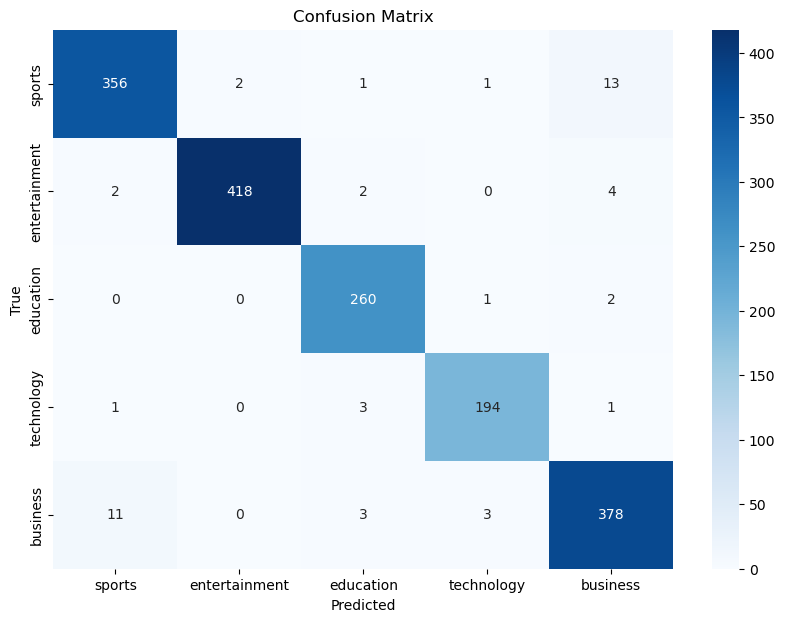

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class labels from the training data
class_labels = y_train.unique()

# Confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

_The confusion matrix demonstrates strong classification performance, with the majority of predictions falling on the diagonal, indicating correct classifications for all five categories._

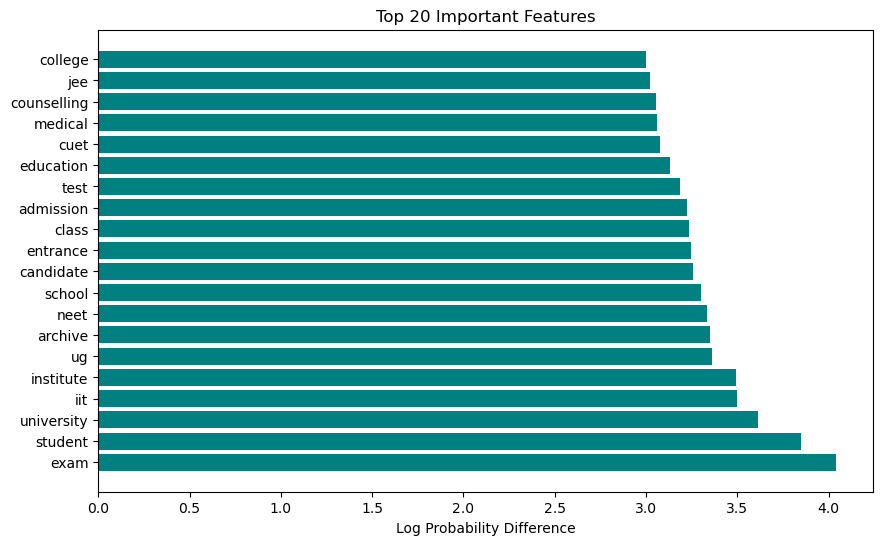

In [79]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train['content'])
X_test_tfidf = tfidf.transform(X_test['content'])

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train) 

# Get the feature names from TfidfVectorizer
feature_names = tfidf.get_feature_names_out()

# Calculate the difference of log probabilities for the classes
class_diff = nb.feature_log_prob_

# Visualize the differences between two specific classes
if class_diff.shape[0] > 1:
    importance = class_diff[1] - class_diff[0] 
else:
    importance = class_diff[0]

# Sort the features based on importance
sorted_idx = importance.argsort()

# Plot the most important features
top_n = 20 
top_features = feature_names[sorted_idx[-top_n:]]
top_importance = importance[sorted_idx[-top_n:]]

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='teal')
plt.xlabel('Log Probability Difference')
plt.title(f'Top {top_n} Important Features')
plt.gca().invert_yaxis()  # Highest coefficients at the top
plt.show()

_These features are the words or phrases that contribute the most to the model's predictions. It provides insight into which terms are most indicative of specific categories, making the model's decisions more interpretable._

In [75]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

# Fit the model on the training data
model.fit(X_train_NB, y_train)

MultinomialNB()

In [77]:
y_pred = model.predict(X_test_NB)

In [79]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_NB, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.5393 ± 0.0060


In [86]:
import mlflow

mlflow.set_tracking_uri("file:///C:/Users/Fransisca Nong/mlruns")

In [90]:
import mlflow.sklearn
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Vectorize text data
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train['content'])  # Select 'content' column
X_test_tfidf = tfidf.transform(X_test['content'])

# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Evaluate model
y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

# Get feature importance
feature_names = tfidf.get_feature_names_out()
class_diff = nb.feature_log_prob_

if class_diff.shape[0] == 2:
    importance = class_diff[1] - class_diff[0]  
else:
    importance = np.mean(class_diff, axis=0)  

sorted_idx = importance.argsort()
top_n = 20
top_features = feature_names[sorted_idx[-top_n:]]
top_importance = importance[sorted_idx[-top_n:]]

# MLflow run and log data
with mlflow.start_run():
    
    input_example = np.array(X_test_tfidf[0].toarray())  # Convert sparse matrix row to NumPy array
    mlflow.sklearn.log_model(nb, "naive_bayes_model", input_example=input_example)

    # Log accuracy
    accuracy = accuracy_score(y_test, nb.predict(X_test_tfidf))
    mlflow.log_metric("accuracy", accuracy)
    
    # Save the vectorizer
    joblib.dump(tfidf, "tfidf_vectorizer.pkl")
    mlflow.log_artifact("tfidf_vectorizer.pkl")

    print(f"Logged Naive Bayes model with accuracy: {accuracy:.4f} to MLflow")
    
 # MLflow URI(Uniform Resource Identifier)
    tracking_uri = mlflow.get_tracking_uri()
    print(f"MLflow URI: {tracking_uri}")
    
# Save the model locally
joblib.dump(nb, "best_naive_bayes.pkl")
print("Best Naive Bayes model saved locally as 'best_naive_bayes.pkl'")

Logged Naive Bayes model with accuracy: 0.9650 to MLflow
MLflow URI: file:///C:/Users/Fransisca Nong/mlruns
Best Naive Bayes model saved locally as 'best_naive_bayes.pkl'
